# 数据处理+特征工程
train_x.shape = (1381, 1246)
test_x.shape  = (150, 1246)

In [1]:
# -*- coding: UTF-8 -*-
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import sparse
import warnings
import time
import sys
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 10)

In [2]:
train = pd.read_csv('jinnan_round1_train_20181227.csv', encoding = 'gb18030')
test  = pd.read_csv('jinnan_round1_testA_20181227.csv', encoding = 'gb18030')

In [3]:
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,96.991404,96.991404,float64
7,A7,75,89.326648,89.326648,object
8,A8,8,89.326648,89.326648,float64
39,B11,37,60.816619,60.816619,object
38,B10,180,17.478510,17.478510,object
3,A3,3,3.008596,95.702006,float64
29,B1,21,0.716332,53.796562,float64
23,A23,3,0.214900,99.641834,float64
21,A21,12,0.214900,89.828080,float64
30,B2,3,0.143266,98.424069,float64


In [4]:
stats = []
for col in test.columns:
    stats.append((col, test[col].nunique(), test[col].isnull().sum() * 100 / test.shape[0], test[col].value_counts(normalize=True, dropna=False).values[0] * 100, test[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,98.000000,98.000000,float64
7,A7,15,88.000000,88.000000,object
8,A8,2,88.000000,88.000000,float64
39,B11,11,59.333333,59.333333,object
38,B10,50,14.666667,14.666667,object
3,A3,2,2.000000,97.333333,float64
25,A25,7,0.666667,42.000000,float64
27,A27,11,0.666667,47.333333,float64
20,A20,52,0.666667,20.000000,object
29,B1,13,0.666667,56.000000,float64


Text(0, 0.5, 'yield')

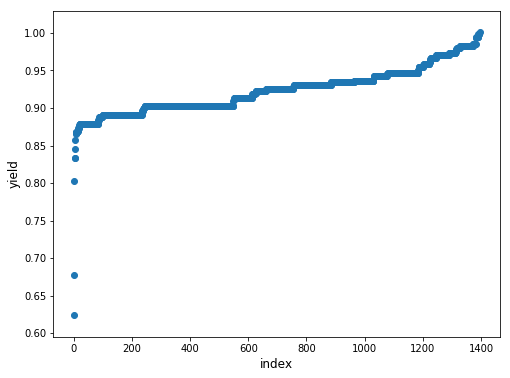

In [5]:
target_col = "收率"

plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
# plt.show()

Text(0.5, 0, 'yield')

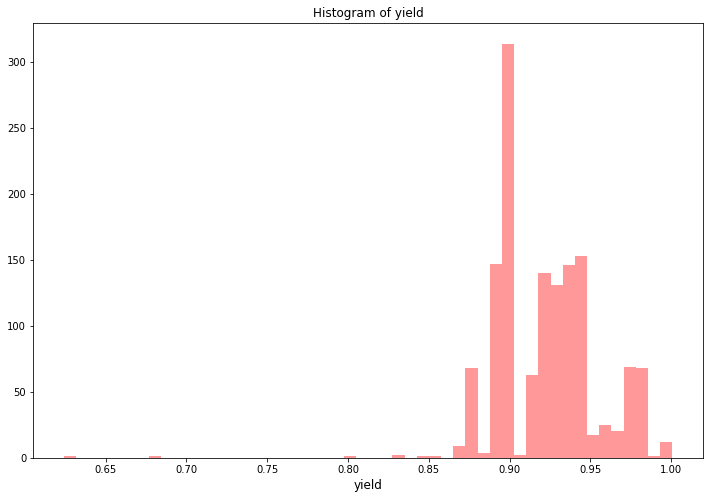

In [6]:
plt.figure(figsize=(12,8))
sns.distplot(train[target_col].values, bins=50, kde=False, color="red")
# train_y = pd.DataFrame(train[target_col].values)
plt.title("Histogram of yield")
plt.xlabel('yield', fontsize=12)
# plt.show()
# train_y = train[target_col]

In [7]:
# 删除类别唯一的特征
for df in [train, test]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

In [8]:
# 删除某一类别占比超过90%的列
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)
        print(col,rate)
# 暂时不删除，后面构造特征需要
good_cols.append('A1')
good_cols.append('A3')
good_cols.append('A4')
# 



A1 0.9863896848137536
A2 0.9699140401146131
A3 0.9570200573065902
A4 0.9570200573065902
B2 0.9842406876790831


In [9]:
# 删除异常值
train = train[train['收率']>0.87]
        
train = train[good_cols]
good_cols.remove('收率')
test  = test[good_cols]

In [10]:
# 合并数据集
target = train['收率']
del train['收率']
data = pd.concat([train,test],axis=0,ignore_index=True)
data = data.fillna(-1)

In [11]:
# #将时间信息转化为小时
# import re
# def t2s(t):
#     try:
#         t,m,s=t.split(":")
#     except:
#         if t=='1900/1/9 7:00':
#             return 7
#         elif t=='1900/1/1 2:30':
#             return -1
#         else:
#             return -1
    
#     try:
#         tm = int(t)*3600+int(m)*60+int(s)

#     except:
#         return -1
    
#     return tm/3600
# for f in ['A5','A9','A11','A14','A16','A24','A26','B5','B7']:
#     data[f] = data[f].apply(t2s)

# def getStartTime(se):

#     try:
#         sh,sm,eh,em=re.split("[:,-]",se)
#     except:
#         if se=='14::30-15:30':
#             return 14.5
#         elif se=='13；00-14:00':
#             return 13
#         elif se=='21:00-22；00':
#             return 21
#         elif se=='22"00-0:00':
#             return 22
#         elif se=='2:00-3;00':
#             return 2
#         elif se=='1:30-3;00':
#             return 1.5
#         elif se=='15:00-1600':
#             return 15
#         elif se=='19:-20:05':
#             return 19
#         else:
#             return -1
        
#     try:
#         timestart = int(sh)+int(sm)/60
#     except:
#         return -1
    
#     return int(timestart)

# data['st6'] = data.apply(lambda df: getStartTime(df['A20']), axis=1)
# data['st9'] = data.apply(lambda df: getStartTime(df['A28']), axis=1)
# data['st10'] = data.apply(lambda df: getStartTime(df['B4']), axis=1)
# data['st13'] = data.apply(lambda df: getStartTime(df['B9']), axis=1)
# data['st14'] = data.apply(lambda df: getStartTime(df['B10']), axis=1)
# data['st15'] = data.apply(lambda df: getStartTime(df['B11']), axis=1)

# # def getNum(se):
# #     try:
# #         example,num=re.split("[-]",se)
# #     except:
# #         return None    
# #     return int(num)
# # data['Id'] = data.apply(lambda df: getNum(df['Id']), axis=1)


# def getDuration(se):
#     timelasting = 0
#     try:
#         sh,sm,eh,em=re.split("[:,-]",se)
#     except:
#         if se=='14::30-15:30':
#             return 1
#         elif se=='13；00-14:00':
#             return 1
#         elif se=='21:00-22；00':
#             return 1
#         elif se=='22"00-0:00':
#             return 2
#         elif se=='2:00-3;00':
#             return 1
#         elif se=='1:30-3;00':
#             return 1.5
#         elif se=='15:00-1600':
#             return 1
#         elif se=='19:-20:05':
#             return 1
#         else:
#             return -1

        
#     try:
#         if(int(eh)>int(sh)):
#             timelasting = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600
#         elif(int(eh)<int(sh)):
#             timelasting = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600 + 24
#     except:
#         return -1
#     return int(timelasting)

# for f in ['A20','A28','B4','B9','B10','B11']:
#     data[f] = data[f].apply(getDuration)
def timeTranSecond(t):
    try:
        t,m,s=t.split(":")
    except:
        if t=='1900/1/9 7:00':
            return 7*3600/3600
        elif t=='1900/1/1 2:30':
            return (2*3600+30*60)/3600
        elif t==-1:
            return -1
        else:
            return 0
    
    try:
        tm = (int(t)*3600+int(m)*60+int(s))/3600
    except:
        return (30*60)/3600
    
    return tm
for f in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
    try:
        data[f] = data[f].apply(timeTranSecond)
    except:
        print(f,'应该在前面被删除了！')

def getDuration(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
    except:
        if se == -1:
            return -1 
        
    try:
        if int(sh)>int(eh):
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600 + 24
        else:
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600
    except:
        if se=='19:-20:05':
            return 1
        elif se=='15:00-1600':
            return 1
    
    return tm
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f] = data.apply(lambda df: getDuration(df[f]), axis=1)

In [12]:
data['样本id'] = data['样本id'].apply(lambda x: int(x.split('_')[1]))

categorical_columns = [f for f in data.columns if f not in ['样本id']]
numerical_columns = [f for f in data.columns if f not in categorical_columns]

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1531 entries, 0 to 1530
Data columns (total 36 columns):
样本id    1531 non-null int64
A5      1531 non-null float64
A6      1531 non-null float64
A7      1531 non-null float64
A8      1531 non-null float64
A9      1531 non-null float64
A10     1531 non-null int64
A11     1531 non-null float64
A12     1531 non-null float64
A14     1531 non-null float64
A15     1531 non-null float64
A16     1531 non-null float64
A17     1531 non-null float64
A19     1531 non-null int64
A20     1531 non-null float64
A21     1531 non-null float64
A22     1531 non-null float64
A24     1531 non-null float64
A25     1531 non-null object
A26     1531 non-null float64
A27     1531 non-null float64
A28     1531 non-null float64
B1      1531 non-null float64
B4      1531 non-null float64
B5      1531 non-null float64
B6      1531 non-null int64
B7      1531 non-null float64
B8      1531 non-null float64
B9      1531 non-null float64
B10     1531 non-null float64
B1

In [14]:
# 有风的冬老哥，在群里无意爆出来的特征，让我提升了三个个点，当然也可以顺此继续扩展
data['b14/a1_a3_a4_a19_b1_b12'] = data['B14']/(data['A1']+data['A3']+data['A4']+data['A19']+data['B1']+data['B12'])

numerical_columns.append('b14/a1_a3_a4_a19_b1_b12')
# data
# del data['A1']
# del data['A3']
# del data['A4']
# categorical_columns.remove('A1')
# categorical_columns.remove('A3')
# categorical_columns.remove('A4')
# medicine_list = ['A1','A2','A3','A4','A19','A21','A22','B1','B2','B12','B14'] 
# for ff1 in medicine_list:
#     i=0
#     for ff2 in medicine_list:
#         j=0
#         if(i+j<10):
#             col_name = ff1+"-"+ff2
#             data[col_name] = data[ff1]-data[ff2]
#             j = j + 1
#         i= i + 1        
# medicine_list = ['A5','A9','A11','A14','A16','A24','A26','B5','B7','st6','st9','st10','st13','st14','st15'] 
# for ff1 in medicine_list:
#     i=0
#     for ff2 in medicine_list:
#         j=0
#         if(i+j<11):
#             col_name = ff1+"-"+ff2
#             data[col_name] = data[ff1]-data[ff2]
#             j = j + 1
#         i= i + 1        
# data['B9-B14'] = abs(data['B9']-data['B14'])
# data['B9-B1'] = abs(data['B9']-data['B14'])
# data['B9-B12'] = abs(data['B9']-data['B14'])
data

,样本id,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A20,A21,A22,A24,A25,A26,A27,A28,B1,B4,B5,B6,B7,B8,B9,B10,B11,B12,B14,A1,A3,A4,b14/a1_a3_a4_a19_b1_b12
0,1528,13.5,38.0,-1.000000,-1.0,15.5,100,16.5,102.0,17.5,103.0,18.5,104.0,300,0.5,50.0,9.0,22.0,75,22.5,70.0,0.5,350.0,1.0,8.0,65,11.5,45.0,1.5,1.5,-1.0,800.0,400,300,405.0,700,0.140105
1,1698,14.0,29.0,-1.000000,-1.0,16.0,101,17.0,103.0,18.0,104.0,19.0,105.0,200,1.0,50.0,9.0,20.0,80,21.0,73.0,1.0,320.0,1.0,23.0,80,6.0,45.0,1.5,1.5,1.0,1200.0,400,300,405.0,700,0.128000
2,639,14.0,29.0,-1.000000,-1.0,16.0,102,17.0,103.0,18.0,104.0,19.0,105.0,200,0.5,50.0,9.0,20.0,79,21.0,73.0,1.0,320.0,1.0,23.0,80,1.0,45.0,1.5,1.5,1.0,1200.0,400,300,405.0,700,0.128000
3,483,1.5,38.0,-1.000000,-1.0,3.0,100,4.0,102.0,5.0,103.0,6.0,104.0,200,0.5,50.0,10.0,7.5,70,8.0,78.0,1.0,290.0,1.0,15.5,65,18.0,45.0,1.5,1.5,-1.0,800.0,400,300,405.0,700,0.148423
4,617,22.0,29.0,-1.000000,-1.0,0.0,101,1.0,103.0,2.0,104.0,3.0,105.0,200,1.0,50.0,9.0,4.0,80,5.0,73.0,1.0,320.0,1.0,7.0,80,9.0,45.0,1.5,1.5,1.0,1200.0,420,300,405.0,700,0.134400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526,502,11.0,24.0,-1.000000,-1.0,12.5,100,13.5,101.0,14.5,103.0,15.5,103.0,300,0.5,50.0,10.0,17.0,70,17.5,78.0,1.0,340.0,1.5,8.0,65,10.5,45.0,1.5,1.5,-1.0,800.0,440,300,405.0,700,0.154657
1527,1951,21.0,29.0,-1.000000,-1.0,23.0,102,0.0,104.0,1.0,105.0,2.0,106.0,200,1.0,50.0,9.0,3.0,80,4.0,73.0,1.0,320.0,1.0,6.0,80,8.0,45.0,4.0,-1.0,-1.0,1200.0,440,300,405.0,700,0.140800
1528,386,7.5,41.0,7.666667,80.0,9.0,100,10.0,103.0,11.0,102.0,12.0,102.0,300,0.5,50.0,9.0,15.5,70,16.0,75.0,0.5,370.0,1.5,1.5,40,4.5,20.0,1.5,1.5,-1.0,800.0,440,300,405.0,700,0.153043
1529,362,2.0,36.0,2.166667,80.0,3.5,100,4.5,102.0,5.5,102.0,6.5,102.0,300,0.5,50.0,9.0,7.0,70,7.5,75.0,0.5,370.0,2.0,13.5,65,17.0,45.0,1.5,1.5,-1.0,800.0,420,300,405.0,700,0.146087


In [15]:
del data['A1']
del data['A3']
del data['A4']

categorical_columns.remove('A1')
categorical_columns.remove('A3')
categorical_columns.remove('A4')


#label encoder
for f in categorical_columns:
    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
train = data[:train.shape[0]]
test  = data[train.shape[0]:]
train.shape

(1381, 34)

In [16]:
train['target'] = target
train['intTarget'] = pd.cut(train['target'], 5, labels=False)
train = pd.get_dummies(train, columns=['intTarget'])
li = ['intTarget_0.0','intTarget_1.0','intTarget_2.0','intTarget_3.0','intTarget_4.0']
mean_columns = []
for f1 in categorical_columns:
    cate_rate = train[f1].value_counts(normalize=True, dropna=False).values[0]
    if cate_rate < 0.90:
        for f2 in li:
            col_name = 'B14_to_'+f1+"_"+f2+'_mean'
            mean_columns.append(col_name)
            order_label = train.groupby([f1])[f2].mean()
            train[col_name] = train['B14'].map(order_label)
            miss_rate = train[col_name].isnull().sum() * 100 / train[col_name].shape[0]
            if miss_rate > 0:
                train = train.drop([col_name], axis=1)
                mean_columns.remove(col_name)
            else:
                test[col_name] = test['B14'].map(order_label)
train_y = train['target']                
train.drop(li+['target'], axis=1, inplace=True)
train_x = train
test_x = test
print(train.shape)
print(test.shape)

(1381, 109)
(150, 109)


In [17]:

# train_x = train[mean_columns+numerical_columns].values
# test_x = test[mean_columns+numerical_columns].values
# # one hot
# enc = OneHotEncoder()
# for f in categorical_columns:
#     enc.fit(data[f].values.reshape(-1, 1))
#     train_x = sparse.hstack((train_x, enc.transform(train[f].values.reshape(-1, 1))), 'csr')
#     test_x = sparse.hstack((test_x, enc.transform(test[f].values.reshape(-1, 1))), 'csr')
# print(train_x.shape)
# print(test_x.shape)
# train_x = pd.DataFrame(train_x.todense())
# test_x = pd.DataFrame(test_x.todense())
# print(type(train_x))
# print(type(test_x))
# xxx = pd.concat([train_x,train_y],axis = 1)
# print(xxx.shape)
# print(type(xxx))

In [18]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)

(1381, 109)
(150, 109)
(1381,)


# SVM

In [19]:
# from sklearn import preprocessing
# from sklearn import linear_model, svm, gaussian_process
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split
# import numpy as np
# x = train_x
# y = train_y

# x_scaled = preprocessing.StandardScaler().fit_transform(x)
# y_scaled = preprocessing.StandardScaler().fit_transform(y)
# X_train,X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)


In [20]:
# clfs = {
#         'svm':svm.SVR(), 
#         'RandomForestRegressor':RandomForestRegressor(n_estimators=400),
#         'BayesianRidge':linear_model.BayesianRidge()
#        }
# for clf in clfs:
#     try:
#         clfs[clf].fit(X_train, y_train)
#         y_pred = clfs[clf].predict(X_test)
#         print(clf + " cost:" + str((y-y_pred)**2)/(2*len(y)))
#     except Exception as e:
#         print(clf + " Error:")
#         print(str(e))
        

# XGBoost(未完成)

In [21]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))/(2*len(y))

In [22]:
# X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=7)
# # fit model on all training data
# model = XGBClassifier()
# model.fit(X_train, y_train)
# plot_importance(model)
# pyplot.show()
# # make predictions for test data and evaluate
# y_pred = model.predict(X_test)


In [23]:
# print(y_test.shape)
# print(y_pred.shape)
# accuracy = ((y_test-y_pred)**2).mean()/2
# print("Accuracy = {}".format(accuracy))

In [24]:
# thresholds = sorted(model.feature_importances_)
# print(thresholds)
# for thresh in thresholds:
#     # select features using threshold
#     selection = SelectFromModel(model, threshold=thresh, prefit=True)
#     select_X_train = selection.transform(X_train)
#     # train model
#     selection_model = XGBClassifier()
#     selection_model.fit(select_X_train, y_train)
#     # eval model
#     select_X_test = selection.transform(X_test)
#     y_pred = selection_model.predict(select_X_test)
#     accuracy = ((y_test-y_pred)**2).mean()/2
#     print("Accuracy = {}".format(accuracy))

In [25]:
# X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=7)
# lgb_train = lgb.Dataset(X_train, Y_train)
# lgb_test = lgb.Dataset(X_test, Y_test, reference=lgb_train)

In [26]:
# params = {
#     'num_leaves': 5,
#     'metric': ('l1', 'l2'),
#     'verbose': 0
# }

# evals_result = {}  # to record eval results for plotting

# print('Starting training...')
# # train
# gbm = lgb.train(params,
#                 lgb_train,
#                 num_boost_round=100,
#                 valid_sets=[lgb_train, lgb_test],
#                 feature_name=['f' + str(i + 1) for i in range(X_train.shape[-1])],
#                 categorical_feature=[21],
#                 evals_result=evals_result,
#                 verbose_eval=10)

# print('Plotting metrics recorded during training...')
# ax = lgb.plot_metric(evals_result, metric='l1')
# plt.show()

# print('Plotting feature importances...')
# ax = lgb.plot_importance(gbm, max_num_features=10)
# plt.show()


In [27]:
def get_lgb_stack_data(params,rounds,train,col,label,test):
    ID = []
    train = train.reset_index(drop=True)
    kf = KFold(n_splits=5,shuffle=False)
    i=0
    R2_Score = []
    RMSE = []
    evals_result0 = {}  # to record eval results for plotting
    for train_index, test_index in kf.split(train_x,pd.DataFrame(train_y)):
        print("Training "+str(i+1)+' Fold')
        X_train, X_test = train_x.iloc[train_index],train_x.iloc[test_index]
        y_train, y_test = train_y[train_index],train_y[test_index]
        train_lgb=lgb.Dataset(X_train[col],y_train)
        model = lgb.train(params,
                          train_lgb,
                          num_boost_round=rounds)
        pred = model.predict(X_test[col])
        X_test['label'] = list(y_test)
        X_test['predicted'] = pred
        r2 = score(y_test,pred)
        print('R2 Scored of Fold '+str(i+1)+' is '+str(r2))
        
  
        if i==0:
            Final = X_test
        else:
            Final = Final.append(X_test,ignore_index=True)
        i+=1
    lgb_train_ = lgb.Dataset(train[col],label)
    print('Start Training')
    model_ = lgb.train(params,
                       lgb_train_,
                       num_boost_round=rounds,
                       evals_result=evals_result0)

    
#     print('Plotting metrics recorded during training...')
#     ax = lgb.plot_metric(evals_result0, metric='l1')
#     plt.show()

    print('Plotting feature importances...')
    ax = lgb.plot_importance(model_, max_num_features=20)
    plt.show()
    
    Final_pred = model_.predict(test[col])

    print('Calculating In-Bag R2 Score')
    print(score(train_y, model.predict(train[col])))

    return Final,Final_pred 
def score(predictions, targets):
    return ((predictions - targets) ** 2).mean()/2


Training 1 Fold
R2 Scored of Fold 1 is 0.42622930839416057
Training 2 Fold
R2 Scored of Fold 2 is 0.4278569029779411
Training 3 Fold
R2 Scored of Fold 3 is 0.42797009987179485
Training 4 Fold
R2 Scored of Fold 4 is 0.42679311269230763
Training 5 Fold
R2 Scored of Fold 5 is 0.42802804014598544
Start Training
Plotting feature importances...


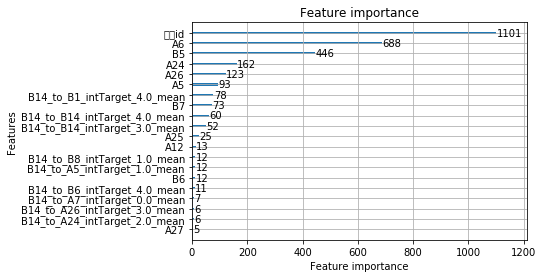

Calculating In-Bag R2 Score
0.42737477901903365


In [28]:
params = {
            'objective': 'regression',
            'metric': ('l1', 'l2'),
            'boosting': 'gbdt',
            'learning_rate': 0.0045 , #small learn rate, large number of iterations
            'verbose': 0,
            'num_iterations': 500,
            'bagging_fraction': 0.95,
            'bagging_freq': 1,
            'bagging_seed': 42,
            'feature_fraction': 0.95,
            'feature_fraction_seed': 42,
            'max_bin': 100,
            'max_depth': 3,
            'num_rounds': 800
        }
col = list(test.columns)
lgb_train, lgb_test = get_lgb_stack_data(params,800,pd.DataFrame(train_x),col,pd.DataFrame(train_y),pd.DataFrame(test_x))

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1531 entries, 0 to 1530
Data columns (total 34 columns):
样本id                       1531 non-null int64
A5                         1531 non-null int64
A6                         1531 non-null int64
A7                         1531 non-null int64
A8                         1531 non-null int64
A9                         1531 non-null int64
A10                        1531 non-null int64
A11                        1531 non-null int64
A12                        1531 non-null int64
A14                        1531 non-null int64
A15                        1531 non-null int64
A16                        1531 non-null int64
A17                        1531 non-null int64
A19                        1531 non-null int64
A20                        1531 non-null int64
A21                        1531 non-null int64
A22                        1531 non-null int64
A24                        1531 non-null int64
A25                        1531 non-null int64
